## ImageNet Data loader for LUAB

### Requirements
- elementpath
- wget
- timm
- cv2
- torch
- torchvision
- matplotlib

In [93]:
import numpy as np
import cv2
import json
import random

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import timm
from timm.data import create_transform
import xml.etree.ElementTree as ET


import torchvision.transforms.functional as F
from matplotlib import pyplot as plt

import wget
wget.download("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt")

In [94]:
def load_points(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    points = []
    for obj in root.findall("metadata"):
        if obj.find("selected").text == "True":
            selected_point = obj.find("selectedRecord")
            points.append([
                float(selected_point.find("x").text),
                float(selected_point.find("y").text),
            ])

    return np.array(points)

    
def get_imagenet_selected_point_info(image_path, xml_root):
    """
    image_path: /img_root/Data/CLS-LOC/train/n15075141/n15075141_9993.JPEG
    box_xml: /xml_root/Annotations/CLS-LOC/train/n15075141/n15075141_9993.xml

    Returns:
      boxes: Numpy array or None
      sizes: [width, height, depth] or None
      None is returned if no box sup exists.
    """
    fragments = image_path.split("/")
    file_name_no_extension = fragments[-1].split('.')[0]
    source_xml = os.path.join(xml_root, "Annotations", fragments[-4], "train_enriched", fragments[-2],
                           file_name_no_extension + '.xml')

    if not os.path.isfile(source_xml):
        return None

    return load_points(source_xml)


def check_in_point(loc_info, gt_points):
    if len(gt_points) != 0:
        img_h, img_w = loc_info['img_h'], loc_info['img_w']
        is_flip = loc_info['f']
        crop_x0 = loc_info['j'] / img_w
        crop_y0 = loc_info['i'] / img_h
        crop_x1 = crop_x0 + loc_info['w'] / img_w
        crop_y1 = crop_y0 + loc_info['h'] / img_h

        avg_point = sum(gt_points) / len(gt_points)
        if is_flip:
            crop_x0, crop_x1 = 1 - crop_x1, 1 - crop_x0
            avg_point[0] = 1 - avg_point[0]

        return (crop_x0 <= avg_point[0] and crop_x1 >= avg_point[0]) and \
               (crop_y0 <= avg_point[1] and crop_y1 >= avg_point[1]), \
               np.array([(avg_point[0] - crop_x0) * img_w / loc_info['w'], (avg_point[1] - crop_y0) * img_h / loc_info['h']])
    
    return False, None


def compute_cls(original_label, LUAB_points, loc_info, class_gt=False, num_classes=1000,
                loss_weight=1):
    is_fg = False
    weight = np.array(1, dtype=np.float32)
    if LUAB_points is not None:
        is_fg, fg_point = check_in_point(loc_info=loc_info, gt_points=LUAB_points)
                      
    if not is_fg or LUAB_points is None:
        weight = np.array(0, dtype=np.float32)
        fg_point = np.array([-1, -1], dtype=np.float32)

    return original_label, weight, fg_point

                    
class RRCFlipReturnParams(timm.data.transforms.RandomResizedCropAndInterpolation):
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.

        Returns:
            PIL Image: Randomly cropped and resized image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        if isinstance(self.interpolation, (tuple, list)):
            interpolation = random.choice(self.interpolation)
        else:
            interpolation = self.interpolation
        processed_img = F.resized_crop(img, i, j, h, w, self.size, interpolation)

        f = torch.rand(1) < 0.5
        if f:
            processed_img = F.hflip(processed_img)
        return processed_img, {'i': i, 'j': j, 'h': h, 'w': w, 'f': f, 'img_h': img.size[1], 'img_w': img.size[0]}
                    
                    
class ImageNetwithLUAB(torchvision.datasets.folder.ImageFolder):
    def __init__(self, root, xml_root, transform=None, pre_transform=None,
                 num_classes=1000, loss_weight=1, seed=0):
        super(ImageNetwithLUAB, self).__init__(
            root,
            transform=transform)
        self.xml_root = xml_root
        self.pre_transform = pre_transform
        self.num_classes = num_classes
        self.loss_weight = loss_weight

    def get_point_ingredients(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        image_path = self.imgs[index][0].strip()
        points = get_imagenet_selected_point_info(image_path, self.xml_root)
        sample, loc_info = self.pre_transform(sample)
         
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target, points, loc_info

    def __getitem__(self, index):
        sample, target, points, loc_info = self.get_point_ingredients(index)
                    
        target, weight, fg_point = compute_cls(
            original_label=target,
            LUAB_points=points,
            loc_info=loc_info,
            num_classes=self.num_classes,
            loss_weight=self.loss_weight)

        return sample, (target, weight, fg_point, np.array([loc_info['w'], loc_info['h']], dtype=np.float32))

    

### Building data loaders

In [95]:
import os
root_train = '/home/tmp/dataset/ILSVRC2015/'
xml_path = os.path.join(root_train, 'train')

input_size = 224
batch_size = 8
num_workers = 10

_, transform_2nd, transform_final = create_transform(
        input_size=input_size,
        is_training=True,
        auto_augment=None,
        color_jitter=0,
        re_prob=0,  
        interpolation='bicubic',
        separate=True
)

dataset_train = ImageNetwithLUAB(
        root=root_train,
        xml_root=xml_path,
        num_classes=1000,
        transform=transforms.Compose([transform_2nd, transform_final]),
        pre_transform=RRCFlipReturnParams(
            size=input_size,
            scale=(0.08, 1),
            interpolation='bicubic'),
    )
    
train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )
    

    

### Visualizing the image and annotated point

In [96]:
def draw_text(img, text, height, width,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),              
          font_scale=2,
          font_thickness=2,
          text_color=(255, 255, 255),
          text_color_bg=(0, 0, 0),
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    if x + text_w > width:
        x = x - text_w//2
    if y + text_h > height:
        y = y - text_h//2
    cv2.rectangle(img, (x,y), (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size


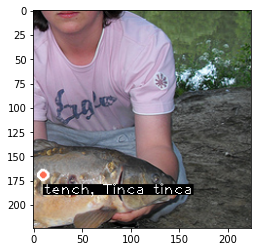

In [134]:
def t2n(t):
    return np.transpose(t.detach().cpu().numpy().astype(np.float64), (1,2,0)) 

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    rgb = tuple(int(value[i:i+lv//3], 16) for i in range(0, lv, lv//3))
    return rgb[::-1]

with open('./metadata/imagenet1000_clsidx_to_labels.txt', 'r') as f:
    data_list = f.read()

class_idx_to_label = eval(str(data_list))
it = iter(train_loader)
img, target = next(it)
img, target = next(it)

img_idx = 0
points = target[2][img_idx] * np.array([224, 224])
img = ((t2n(img[img_idx]).copy() * timm.data.constants.IMAGENET_DEFAULT_STD + timm.data.constants.IMAGENET_DEFAULT_MEAN))*255
if target[1][0] > 0:
    blend = cv2.circle(img, (int(points[0]), int(points[1])), thickness=-1, lineType=8, radius=5, color=hex_to_rgb("526dfe"))
    blend = cv2.circle(blend, (int(points[0]), int(points[1])), thickness=2, lineType=8, radius=5, color=(255,255,255))
    draw_text(img=img, text=class_idx_to_label[target[0][img_idx].item()], width=224, height=224, pos=(int(points[0]), int(points[1])+10),
                     text_color=(255,255,255),
                     text_color_bg=(0,0,0),
                     font_scale=1,
                     font_thickness=1)    
plt.imshow(img.astype(np.uint8))